# Transfer Learning with MobileNetV2

In [1]:
# Note

# A pre-trained model is a network that's already been trained on a large dataset and saved.
# The pre-trained model (MobileNetV2) that we'll be using here has been pre-trained on ImageNet, a dataset 
# containing over 14 million images and 1000 classes.

In [2]:
### v1.1

In [3]:
# Importing the necessary packages

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### Creating the dataset

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

# The original dataset has some mislabelled images in it as well.

# Note 1

# 'image_size' means all images from the disk will be resized to 160 x 160 pixels before being used in training or validation
# datasets.
# The 'image_size' of train_dataset is same as 'image_size' of validation_dataset which is same 'image_size' of test/real world
# dataset on which the model runs. This is because CNNs require a fixed input size and also whatever the model is being
# trained on, it should be validated and tested on similar kind of data.

# shuffle = True ensures that if the minibatches created from the dataset have indices 0,1,2,3,4,....n, then during first epoch,
# the order of minibatches maybe 0,1,2,3....n, but during the second epoch, this order may change.
# Similarly during validation also this order may change.

# setting 'seed=42' ensures that same images are assigned to the training set and the same images are assigned to the 
# validation set each time we run the loading_dataset code, given the same dataset and split ratio.

# For seed = x, the training set consists of a set A of images and the validation set consists of a set B of images. 
# A and B are non overlapping sets. For seed = y, the training set consists of a set A' of images and the validation set 
# consists of a set B' of images. A' and B' are non overlapping sets as well.

# The same 'validation_split' value must be set for both 'train_dataset' and 'validation_dataset'.
# If we set validation_split=0.2, it means that 20% of the dataset will be used for validation, and the remaining 80% will be 
# used for training.

# Note 2

# When we call image_dataset_from_directory and provide the path to the top-level directory ("dataset/" in this example), 
# the function automatically scans the subdirectories (dogs and cats) and assigns labels to the images based on these 
# subdirectory names. In this case, all images in the dogs directory are labeled as "dogs", and all images in the cats 
# directory are labeled as "cats".

# This method of organizing and labeling data is very common because it simplifies the process of preparing datasets for 
# training machine learning models.

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [5]:
# The MobileNetV2 and other pre-trained models are very flexible and accept the input images in different sizes and not just in
# the size (160,160). This is because they have the GlobalAveragePooling2D layers before the fully connected layers.

# The GlobalAveragePooling2D layers convert each layer into a single value making the output size of the pooling layer 
# independent of the input image's dimensions. This allows the model to adapt to different input sizes and feed the 
# result into fully connected layers, which do require fixed-size inputs.

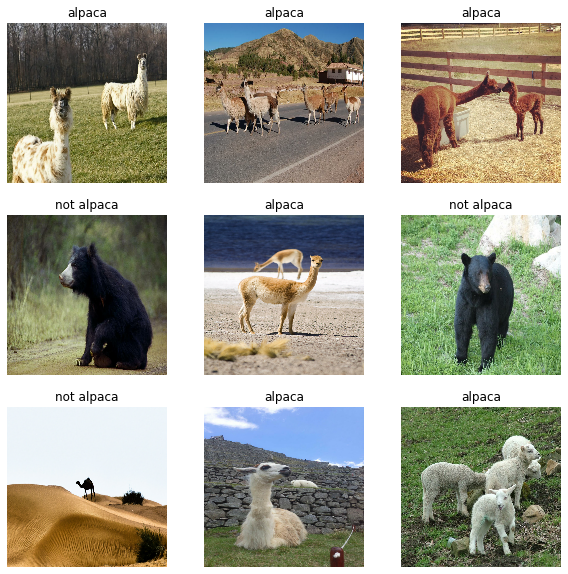

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
# When we specify .take(1), it means we are creating a new dataset that contains only the first mini-batch of our
# training dataset.

### Preprocessing and Augmentation

In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Using prefetch() prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and 
# keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to 
# preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, 
# the data doesn't need to fit into memory.


# Initial Loading: A batch of data is loaded into memory and processed (e.g., decoded, resized, augmented).
# Training: The model begins training on the currently loaded batch.
# Prefetching: While the model is training, the next batch(es) of data are loaded and prepared in the background. 
# The buffer_size determines how many of these batches are prepared in advance.

In [8]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

# Note

# We can directly pass a list of layers to the tf.keras.Sequential() constructor.
# Alternatively, we can start with an empty tf.keras.Sequential() model and then add layers one by one using the .add() method.

# RandomFlip('horizontal') - Flip along the horizontal axis. 
# The RandomFlip('horizontal') layer in TensorFlow's Keras API will either flip an image along the horizontal axis or 
# leave it unchanged

# RandomRotation(0.2) - Each image will be rotated by a random angle within the range of -72 to +72 degrees (0.2*360 = 72)

# Data augmentation doesn't directly increase the number of images in our dataset.
# This means that each epoch can see slightly different versions of each image, thereby effectively increasing the diversity of 
# the training data without physically increasing the dataset size.
# This also means that the weights see different versions of the same image and still classify them correctly.

In [9]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
assert len(augmenter.layers) == 2, "The model must have only 2 layers"

print('\033[92mAll tests passed!')


All tests passed!


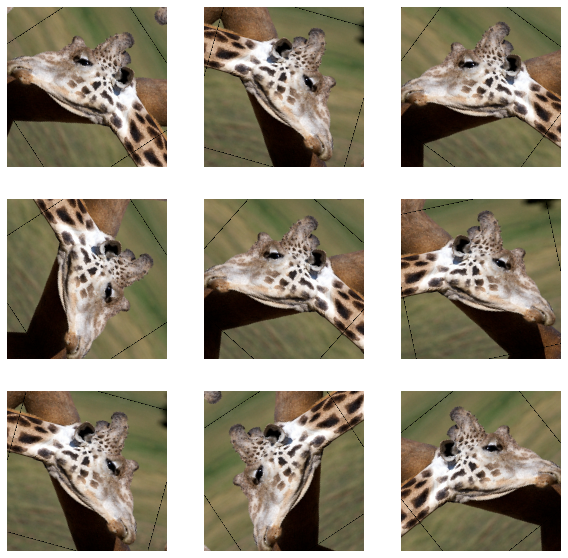

In [10]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')
        
# train_dataset.take(1) takes the first minibatch. first_image is the first image in the first minibatch

# tf.expand_dims(first_image, 0) adds an extra dimension to first_image, converting it from a 3D tensor of 
# shape [height, width, channels] to a 4D tensor of shape [1, height, width, channels]. This is necessary because 
# the data augmentation layers expect a batch of images as input, even if the batch contains only one image.

# The same image undergoes 2 random transformations 9 times and as a result we get 9 variations of the same image.

In [11]:
# Points to remember

# When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
# Use prefetch() to prevent memory bottlenecks when reading from disk
# Give your model more to learn from with simple data augmentations like rotation and flipping.
# When using a pretrained model, it's best to reuse the weights it was trained on.

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# This is the input preprocessing layer of the pre-trained mobilenet_v2 model. Before we use the pre-trained model on our data, 
# it is important to preprocess the data using the same preprocessing layer of the pre-trained mobilenet_v2 model.
# This is because the weights of the pre-trained model have been trained only to process certain kinds of input data and 
# it is essential for our data to be in that format.

### Using MobileNetV2 for Transfer Learning

In [13]:
# MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. 
# It's 155 layers deep and very efficient for object detection and image segmentation tasks, as well as classification tasks.

# Traditional convolutions are often very resource-intensive, and depthwise separable convolutions are able to reduce the 
# number of trainable parameters and operations and also speed up convolutions.

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
# We know IMG_SIZE = (160,160). The tuples are being added.
# Resultant IMG_SHAPE = (160,160,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

# By weights = 'imagenet', it means the weights of MobileNetV2 which have been trained on the imagenet data.
# include_top=True means the fully-connected output layers that were used for classification on the 
# original dataset (in this case, ImageNet) will be present.
# This is useful when you want to use the model for classification tasks involving the same number of classes as the 
# original dataset (1000 classes for ImageNet).

14540800/14536120 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [16]:
# Note the last 2 layers here. They are the so called top layers, and they are responsible of the classification in the model.

nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


In [17]:
image_batch, label_batch = next(iter(train_dataset))
# next(iter(train_dataset)) retrieves the next minibatch

feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [18]:
#Shows the different label probabilities in one tensor 
label_batch

# label_batch contains the labels corresponding to each image in image_batch. The shape of label_batch is 
# typically (batch_size,), with each entry being the label index for each image.

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

In [19]:
base_model.trainable = False
# The above line of code means that we are not further training the pre-trained weights based on our data
image_var = tf.Variable(preprocess_input(image_batch))
# The preprocess_input doesn't automatically convert the image_batch into a tensor. We have to do it manually.
# The above step is not necessary. It isn't necessary to convert into a tensor. The base_model will automatically take care of
# it.
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

# The predictions returned by the base model below follow this format:

# First the class number, then a human-readable label, and last the probability of the image belonging to that class. 
# There are two of these returned for each image in the batch - these the top two probabilities returned for that image.

40960/35363 [==================================] - 0s 0us/step


[[('n02489166', 'proboscis_monkey', 0.10329965),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883611)],
 [('n02125311', 'cougar', 0.1654676), ('n02389026', 'sorrel', 0.10764261)],
 [('n02437312', 'Arabian_camel', 0.2923283),
  ('n02437616', 'llama', 0.27713484)],
 [('n03944341', 'pinwheel', 0.31154886), ('n03047690', 'clog', 0.052500293)],
 [('n02454379', 'armadillo', 0.73107153),
  ('n01990800', 'isopod', 0.038719974)],
 [('n02437312', 'Arabian_camel', 0.25663644),
  ('n02422106', 'hartebeest', 0.12122728)],
 [('n02437616', 'llama', 0.6612557),
  ('n02090721', 'Irish_wolfhound', 0.23782855)],
 [('n02133161', 'American_black_bear', 0.82735676),
  ('n02134418', 'sloth_bear', 0.02925945)],
 [('n01518878', 'ostrich', 0.9267562),
  ('n02002724', 'black_stork', 0.0017766367)],
 [('n01518878', 'ostrich', 0.94954586),
  ('n02018795', 'bustard', 0.0028661634)],
 [('n02437616', 'llama', 0.8699833), ('n02412080', 'ram', 0.076757126)],
 [('n02415577', 'bighorn', 0.2429446), ('n02412080', 'ram', 

In [20]:
# here's a whole lot of labels here, some of them hilariously wrong, but none of them say "alpaca."

# This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when you use the 
# full model, all you get is a bunch of incorrectly classified images.

### Freezing of weights

In [21]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmenter()(inputs)
    
    # Data augmentation doesn't directly increase the number of images in our dataset.
    # This means that each epoch can see slightly different versions of each image, thereby effectively increasing the 
    # diversity of the training data without physically increasing the dataset size.
    # This also means that the weights see different versions of the same image and still classify them correctly.
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    # By setting 'training = False', the batch statistics will not be influenced by the test set during inference and will be 
    # influenced only by the training set.
    # The BN layers will use the moving averages of mean and variance that were computed during training, 
    # rather than calculating them anew based on the current batch of test data, unaffected by the variability in test data.
    
    # Another reason why batch statistics should be influenced only by training set and not by test set is that the 
    # training set minibatch is large whereas it can be only 1 test case that we are predicting and we shouldn't allow such a 
    # small sized test case to influence the batch statistics.  If we allow, then a single outlier test case will change the 
    # batch statistics.
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x)
    # If the input to GlobalAveragePooling2D layer is a tensor of shape (batch_size, height, width, channels), the output shape 
    # after GlobalAveragePooling2D will be (batch_size, channels)
    
    # Since we used 'GlobalAveragePooling2D', we don't need to flatten.
    
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(rate=0.2)(x)
    # Note - Dropout is applied only during the training phase. Even during validation/testing, dropout is not applied.
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(units=1, activation='linear')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [22]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9412608/9406464 [==============================] - 0s 0us/step


In [23]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                    ['Sequential', (None, 160, 160, 3), 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['TensorFlowOpLayer', [(None, 160, 160, 3)], 0],
                    ['Functional', (None, 5, 5, 1280), 2257984],
                    ['GlobalAveragePooling2D', (None, 1280), 0],
                    ['Dropout', (None, 1280), 0, 0.2],
                    ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['TensorFlowOpLayer', [(None, 160, 160, 3)], 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


In [24]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Note
# If 'from_logits' = True, the function will internally apply a sigmoid activation to the logits before calculating the 
# binary crossentropy loss. This is useful and numerically stable when the model's final layer outputs raw logits, 
# which are not constrained to [0, 1].

In [25]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 946ms/step - loss: 0.8131 - accuracy: 0.5000 - val_loss: 0.6789 - val_accuracy: 0.5538
Epoch 2/5
9/9 [==============================] - 7s 792ms/step - loss: 0.6457 - accuracy: 0.6069 - val_loss: 0.6061 - val_accuracy: 0.5846
Epoch 3/5
9/9 [==============================] - 7s 823ms/step - loss: 0.5597 - accuracy: 0.6947 - val_loss: 0.4900 - val_accuracy: 0.6000
Epoch 4/5
9/9 [==============================] - 7s 799ms/step - loss: 0.5279 - accuracy: 0.7099 - val_loss: 0.4787 - val_accuracy: 0.6154
Epoch 5/5
9/9 [==============================] - 7s 811ms/step - loss: 0.4603 - accuracy: 0.7252 - val_loss: 0.3820 - val_accuracy: 0.6923


In [26]:
# Note

# Yes, TensorFlow's Keras API provides flexibility in how you can fit (train) your model, allowing for different types of 
# input data.

# Method 1

# model.fit(x=inputs, y=outputs, epochs=100)

# Method 2

# model.fit(train_dataset, epochs=100)

# In both the above cases, there is no validation.

# Method 3

# model.fit(train_dataset, validation_data=validation_dataset, epochs=100)

# In above case, there is validation

In [27]:
# Note

# The validation accuracy can sometime be higher than the training accuracy due to following reasons

# 1) If there is strong regularization like dropout, then the model may not perform well on the training set but may perform
# better on the validation dataset because during validation dropout is not applied allowing the full capacity of the model to
# be used.

# 2) Small Dataset Size: If the training dataset is small, the model might not have enough data to learn effectively, 
# leading to lower training accuracy. However, if the validation set, by chance, happens to contain examples that are 
# easier for the model to classify, then better validation accuracy.

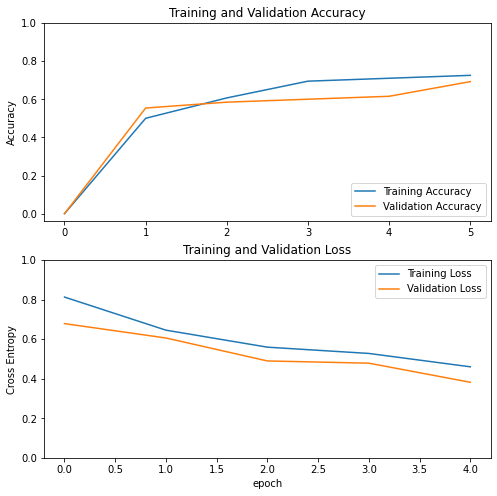

In [28]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next, try some fine-tuning.

### Fine-tuning the Model

In [30]:
# Note

# For fine tuning a pre-trained model, we must use small learning rate to train the later layers on our data because the 
# weights have already been learnt and it is quite close to the minima. So if learning rate is high, the optimizer may diverge. 
# We need to use small learning rate because the weights are not learning for the first time but they are in the final stages of
# learning.

In [31]:
# Note

# When the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, 
# more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, 
# the low-level features can be kept the same, as they have common features for most images. When you add new data, 
# you generally want the high-level features to adapt to it, which is rather like letting the network learn to 
# detect features more related to your data, such as soft fur or big teeth.

# To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, 
# while keeping all the other layers frozen.

In [32]:
base_model = model2.layers[4]
# To understand the above line of code, see the model2 layers in the code cell below.
# The MobileNetV2 model is model2.layers[4]
base_model.trainable = True
# The above line of code makes all the layers of MobileNetV2 model trainable
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']


model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

# Note

# So even if we set 1 layer as trainable, then it is required to compile the model and define the optimizer, 
# the loss function and metrics.

Number of layers in the base model:  155


In [34]:
for i, layer in enumerate(model2.layers):
    print(i, layer.name)

0 input_3
1 sequential_3
2 tf_op_layer_RealDiv
3 tf_op_layer_Sub
4 mobilenetv2_1.00_160
5 global_average_pooling2d_1
6 dropout
7 dense


In [35]:
assert type(loss_function) == tf.python.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')

All tests passed!


In [38]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

# When we specify the 'initial_epoch' parameter, the epoch number starts from 'initial_epoch' + 1 and goes upto 
# total_epochs (inclusive)

Epoch 5/10
9/9 [==============================] - 9s 945ms/step - loss: 0.1523 - accuracy: 0.9389 - val_loss: 0.0681 - val_accuracy: 0.9846
Epoch 6/10
9/9 [==============================] - 8s 943ms/step - loss: 0.1167 - accuracy: 0.9618 - val_loss: 0.0632 - val_accuracy: 0.9538
Epoch 7/10
9/9 [==============================] - 9s 957ms/step - loss: 0.1259 - accuracy: 0.9389 - val_loss: 0.1120 - val_accuracy: 0.9692
Epoch 8/10
9/9 [==============================] - 8s 923ms/step - loss: 0.1065 - accuracy: 0.9504 - val_loss: 0.0918 - val_accuracy: 0.9846
Epoch 9/10
9/9 [==============================] - 8s 923ms/step - loss: 0.1056 - accuracy: 0.9695 - val_loss: 0.2592 - val_accuracy: 0.8769
Epoch 10/10
9/9 [==============================] - 8s 936ms/step - loss: 0.1282 - accuracy: 0.9389 - val_loss: 0.1030 - val_accuracy: 0.9231


In [37]:
print(history.epoch)

[0, 1, 2, 3, 4]


In [39]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

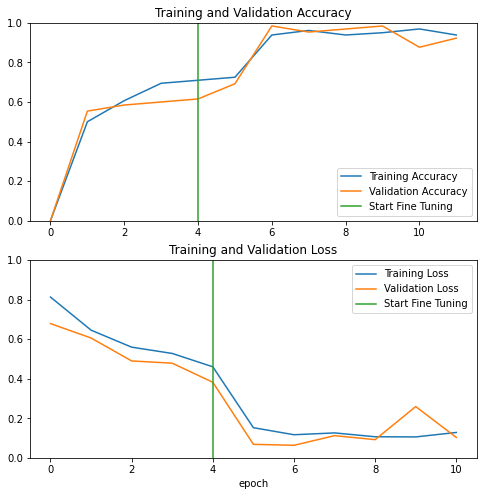

In [40]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Note

# The entire model was initially trained for 5 epochs with all the weights of MobileNetV2 freezed. 
# Then the entire model (already trained for 5 epochs) was trained for 5 more epochs with only the first 120 layer weights of 
# MobileNetV2 freezed and later layer weights trainable.

In [ ]:
# Note

# How fine tuning also helps batch normalization layers?

# Earlier when we freezed the BN layer parameters, the batch statistics (moving average of mean and variance) were based on the 
# imageNet dataset. The batch normalized version of imageNet dataset is of distribution A whereas the 
# batch normalized version of the test dataset is of distribution B. A and B are different. The distribution B inputs are not 
# familiar to the BN layer weights and hence these weights don't predict efficiently.

# Now we unfreeze the BN layer parameters. Now the saved batch statistics (moving average of mean and variance) in memory are 
# based on the custom training dataset and also based on previously imageNet dataset. if more fine-tuning is done, 
# then the batch statistics (moving average of mean and variance) will be more influenced by the moving average of custom 
# training dataset. The batch normalized version of the custom training dataset is of say distribution x. 
# The batch normalized version of the test dataset is of say distribution y . x and y are pretty close (if proper 
# fine-tuning is done). The BN layer weights see a familiar distribution and they predict efficiently.

# The new moving averages is found by considering the earlier moving average of the imageNet and the moving average of the 
# current custom training dataset.

In [ ]:
# Note

# To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer.
# Fine-tune the final layers of your model to capture high-level details near the end of the network and 
# potentially improve accuracy.